# Bayesian Monthly Sensitivity Model
## 3 models are tested, with different ways to calculate the standard deviation
$tmp = \Sigma S*dT$ 

$dY \sim N(tmp,1)$

$dY \sim N(tmp,\sqrt{\Sigma S^2 * \sigma_T^2} )$

$dY \sim N(tmp, free\ paramter)$


In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import pystan

%matplotlib inline

In [2]:
states=['Indiana','Illinois']

In [3]:
temp_states=[]
for i,s in enumerate(states):
    maize_temp=pd.read_table('./Crop_data_files/maize_met_anoms/Maize_Spring_USA_'+s+'_temp_anom_real.csv')
    maize_temp.rename(columns = {'Unnamed: 0':'Year'}, inplace = True)
    temp_states.append(maize_temp)
temp_states=pd.concat(temp_states,keys=states)

In [4]:
# Compile model, for N(tmp,1)
sm=pystan.StanModel(file='BMSM-simp.stan') # reads in the stan model wit sigma = 1

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e7839d65b913f1005fc3976af2843100 NOW.
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/vx/gcsynm8s37z8twk5_jhvwghh0000gn/T/tmpw_10ar8g/stanfit4anon_model_e7839d65b913f1005fc3976af2843100_4854263580108320060.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [5]:
yields=pd.read_table('./Crop_data_files/Maize_median_yield_anoms.csv')

In [6]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data={
    'n_regions':2,
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,1:]).reshape(len(states),np.int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12),
    'd_yields':np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,22:]).astype(float)
}

In [7]:
fit=sm.sampling(data=data,chains=4,iter=1000,verbose=True)

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
fit

Inference for Stan model: anon_model_e7839d65b913f1005fc3976af2843100.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s_temp[0,0]           0.05  1.7e-3   0.07   -0.1 4.1e-3   0.06   0.11    0.2   2000    1.0
s_temp[1,0]           0.05  1.6e-3   0.07  -0.08 1.1e-3   0.05    0.1   0.19   2000    1.0
s_temp[0,1]          -0.13  1.8e-3   0.08  -0.27  -0.18  -0.13  -0.08   0.03   2000    1.0
s_temp[1,1]          -0.06  1.5e-3   0.07  -0.19  -0.11  -0.06  -0.01   0.07   2000    1.0
s_temp[0,2]           -0.1  2.0e-3   0.09  -0.27  -0.16   -0.1  -0.03   0.08   2000    1.0
s_temp[1,2]          -0.15  2.1e-3   0.09  -0.33  -0.21  -0.15  -0.09   0.03   1820    1.0
s_temp[0,3]           0.12  3.0e-3   0.13  -0.14   0.04   0.12   0.22   0.38   2000    1.0
s_temp[1,3]           0.05  3.3e-3   0.13   -0.2  -0.04   0.05   0.14   0.31   1634  

In [9]:
samples=fit.extract()

In [10]:
# Results Edward Pope, linear fit for 'Indiana'

arr = [np.nan,np.nan,np.nan,0.0862453406310437,0.0232350785672767,-0.118245529967667,
       -0.443216771777978,-0.200990287316511,0.0590919010412627,-0.000147094860475441,np.nan,np.nan]
dT_all_states= np.array(temp_states.iloc[:,1:]).reshape(len(states),np.int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12)

dT = dT_all_states[0,:,:]
aT = np.zeros(35)

arr = np.array(arr)
use = np.isfinite(arr)
arr[~use] = 0.0
for i in range(np.size(aT)):
    aT[i] = np.sum(arr*dT[i,:])

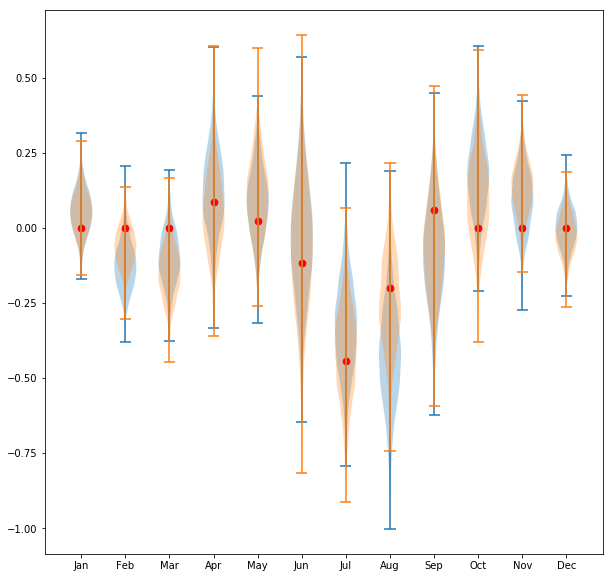

In [11]:
# violin plot for Indiana Illinois
plt.figure(figsize=(10,10))
plt.violinplot(samples['s_temp'][:,0,:]);
plt.violinplot(samples['s_temp'][:,1,:]);
plt.xticks(range(1,13),maize_temp.columns[1:]);
plt.scatter(range(1,13),arr, color = 'red', s = 45);
plt.show()

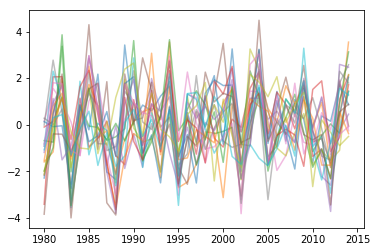

In [12]:
for s in range(0,2000,100):
    plt.plot(range(1980,2015),samples['d_yields_pred'][s,0,:].T,alpha=0.5)

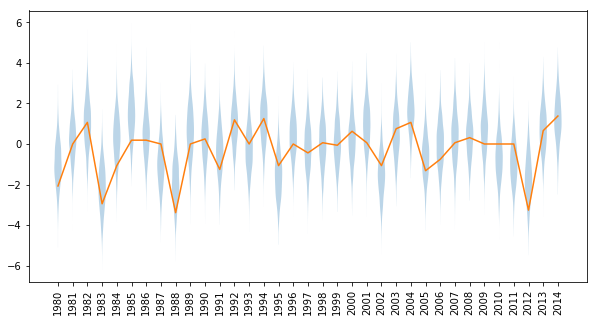

In [13]:
# orange is true results, and blue are the histograms of the output from stan fo 'Indiana'
plt.figure(figsize=(10,5))
plt.violinplot(samples['d_yields_pred'][:,0,:],showextrema=False);
plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
plt.plot(range(1,36),fit.data['d_yields'][0,:])


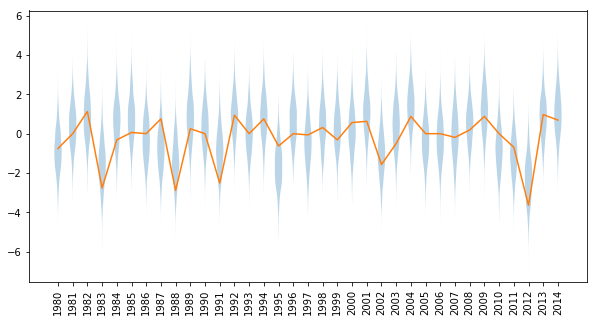

In [14]:
# results for 'Illinois'
plt.figure(figsize=(10,5))
plt.violinplot(samples['d_yields_pred'][:,1,:],showextrema=False);
plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
plt.plot(range(1,36),fit.data['d_yields'][1,:])


In [15]:
sm_SD=pystan.StanModel(file='BMSM-simp_SD.stan') # stan model with sigma = \sqrt{\Sigma S^2 * \sigma_T^2}
# reads in var(T) as extra parameter, 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_03796d5a0612fe07b56c2e7d64de72fc NOW.
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/vx/gcsynm8s37z8twk5_jhvwghh0000gn/T/tmpnmjf7onq/stanfit4anon_model_03796d5a0612fe07b56c2e7d64de72fc_5196580435571568573.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [17]:
data_T= np.array(temp_states.iloc[:,1:]).reshape(len(states),np.int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12)

# calculate the standard deviation in T over the years per month, in this case for two states
sigma_T = np.zeros([np.size(states),12])

for i in range(np.size(states)):
    sigma_T[i,:] = np.std(data_T[i,:,:],axis = 0)


In [18]:
n_years=np.array(yields[yields['Region']=='Maize_Spring_USA_Indiana'].iloc[0,22:]).size
data={
    'n_regions':2,
    'n_years':n_years,
    'd_temp':np.array(temp_states.iloc[:,1:]).reshape(len(states),np.int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12),
    'd_yields':np.array(yields[yields["Region"].isin(['Maize_Spring_USA_'+s for s in states])].iloc[:,22:]).astype(float),
    'var_temp':sigma_T**2
}

In [19]:
fit2=sm_SD.sampling(data=data,chains=4,iter=1000,verbose=True) # fit to the second model

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [20]:
fit2

Inference for Stan model: anon_model_03796d5a0612fe07b56c2e7d64de72fc.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s_temp[0,0]           0.02  1.4e-3   0.06  -0.11  -0.02   0.02   0.06   0.14   2000    1.0
s_temp[1,0]           0.03  1.4e-3   0.06   -0.1  -0.01   0.03   0.07   0.15   2000    1.0
s_temp[0,1]          -0.09  1.5e-3   0.07  -0.22  -0.13  -0.09  -0.04   0.05   2000    1.0
s_temp[1,1]          -0.05  1.4e-3   0.06  -0.18  -0.09  -0.05-6.3e-3   0.07   2000    1.0
s_temp[0,2]          -0.07  1.7e-3   0.08  -0.22  -0.12  -0.07  -0.02    0.1   2000    1.0
s_temp[1,2]          -0.12  1.7e-3   0.08  -0.26  -0.17  -0.12  -0.07   0.03   2000    1.0
s_temp[0,3]           0.13  2.7e-3   0.12  -0.11   0.05   0.13    0.2   0.36   2000    1.0
s_temp[1,3]           0.06  2.6e-3   0.12  -0.16  -0.01   0.06   0.14   0.29   2000  

In [21]:
samples2=fit2.extract()


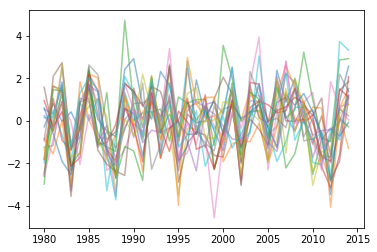

In [22]:
for s in range(0,2000,100):
    plt.plot(range(1980,2015),samples2['d_yields_pred'][s,0,:].T,alpha=0.5)

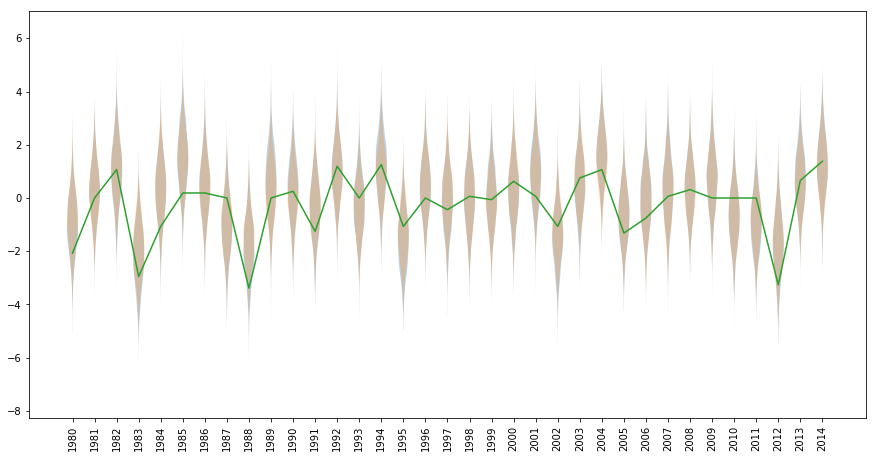

In [23]:
plt.figure(figsize=(15,7.5))
plt.violinplot(samples['d_yields_pred'][:,0,:],showextrema=False);
plt.violinplot(samples2['d_yields_pred'][:,0,:],showextrema=False);
plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
plt.plot(range(1,36),fit.data['d_yields'][0,:])

In [25]:
print(np.sqrt(np.sum(np.mean(samples2['s_temp'][:,0,:],axis = 0)**2*data_T[0,:]**2)))

#print(np.mean(samples['s_temp'][:,0,:],axis = 0))

4.621164450926832


In [26]:
sm3=pystan.StanModel(file='free_stan.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c35c7b27fccfae7dc02f4234be2d3eac NOW.
/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/vx/gcsynm8s37z8twk5_jhvwghh0000gn/T/tmpsdjicy_g/stanfit4anon_model_c35c7b27fccfae7dc02f4234be2d3eac_380570996656338556.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [27]:
fit3=sm3.sampling(data=data,chains=4,iter=1000,verbose=True)

/Users/Steven/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [28]:
fit3

Inference for Stan model: anon_model_c35c7b27fccfae7dc02f4234be2d3eac.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
s_temp[0,0]           0.06  1.6e-3   0.07  -0.09 9.8e-3   0.06    0.1   0.19   2000    1.0
s_temp[1,0]           0.05  1.5e-3   0.07  -0.08 6.6e-3   0.05    0.1   0.18   2000    1.0
s_temp[0,1]          -0.13  1.7e-3   0.08  -0.28  -0.18  -0.12  -0.08   0.03   2000    1.0
s_temp[1,1]          -0.06  1.4e-3   0.06  -0.19   -0.1  -0.06  -0.02   0.06   2000    1.0
s_temp[0,2]           -0.1  1.9e-3   0.09  -0.26  -0.15   -0.1  -0.04   0.08   2000    1.0
s_temp[1,2]          -0.15  1.9e-3   0.09  -0.31   -0.2  -0.15  -0.09   0.02   2000    1.0
s_temp[0,3]           0.13  2.8e-3   0.13   -0.1   0.05   0.13   0.21   0.38   2000    1.0
s_temp[1,3]           0.06  2.9e-3   0.12  -0.18  -0.02   0.06   0.13   0.28   1595  

In [29]:
samples3=fit3.extract()


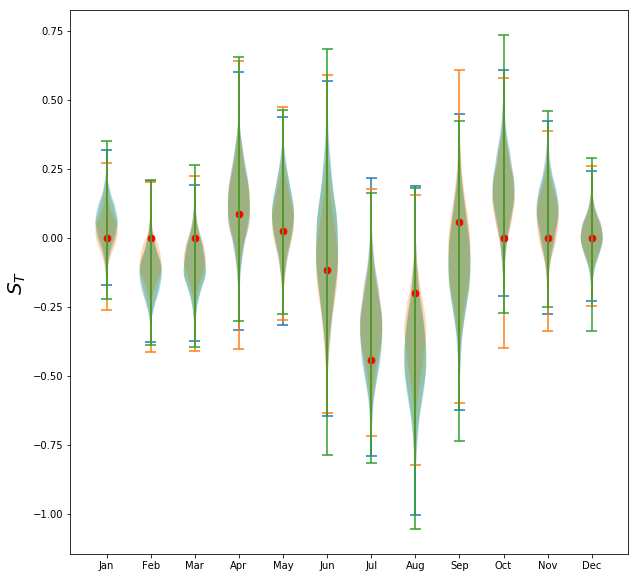

In [30]:
plt.figure(figsize=(10,10)) # violinplot for the 3 models, plus the linear fitting in red for 'Indiana'
plt.violinplot(samples['s_temp'][:,0,:]);
plt.violinplot(samples2['s_temp'][:,0,:]);
plt.violinplot(samples3['s_temp'][:,0,:]);

plt.ylabel('$S_T$', size = 20)


plt.scatter(range(1,13),arr, color = 'red', s = 45);
plt.xticks(range(1,13),maize_temp.columns[1:]);

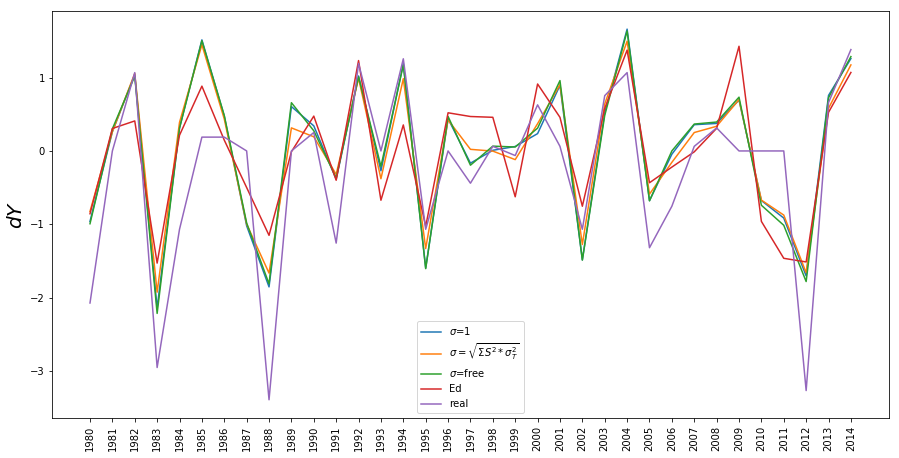

94.29750220344869
95.29288682191215
94.29552980717713
91.60212681004253


In [31]:
plt.figure(figsize=(15,7.5))
#plt.violinplot(samples['d_yields_pred'][:,0,:],showextrema=False);
#plt.violinplot(samples2['d_yields_pred'][:,0,:],showextrema=False);
#plt.violinplot(samples3['d_yields_pred'][:,0,:],showextrema=False);
plt.plot(range(1,36), np.mean(samples['d_yields_pred'][:,0,:],axis = 0) , label = '$\sigma$=1')
plt.plot(range(1,36), np.mean(samples2['d_yields_pred'][:,0,:],axis = 0), label = '$\sigma=\sqrt{\Sigma S^2 * \sigma_T^2}$' )
plt.plot(range(1,36), np.mean(samples3['d_yields_pred'][:,0,:],axis = 0), label = '$\sigma$=free' )
plt.plot(range(1,36), aT, label = 'Ed' )

plt.xticks(range(1,36),np.arange(1980,2015),rotation=90);
plt.plot(range(1,36),fit.data['d_yields'][0,:], label = 'real')
plt.ylabel('$dY$', size = 20)

plt.legend()
plt.show()

#the sum of the square deviations of the 3 models 
print(np.sum(np.mean(samples['d_yields_pred'][:,0,:],axis = 0)-fit.data['d_yields'][0,:])**2)
print(np.sum(np.mean(samples2['d_yields_pred'][:,0,:],axis = 0)-fit.data['d_yields'][0,:])**2)
print(np.sum(np.mean(samples3['d_yields_pred'][:,0,:],axis = 0)-fit.data['d_yields'][0,:])**2)
print(np.sum(aT-fit.data['d_yields'][0,:])**2)


In [32]:
dataT= np.array(temp_states.iloc[:,1:]).reshape(len(states),np.int(np.array(temp_states.iloc[:,1:]).shape[0]/len(states)),12)
print(np.std(dataT[0,:,:],axis =1 ))


[1.62304477 1.22202291 2.43224907 2.30350168 2.47063071 2.25650395
 1.1436583  1.42217752 1.49793652 2.48964782 1.94539362 1.3923486
 1.6249934  1.23524549 1.93118171 1.55261971 1.37654308 1.47121967
 1.61794042 1.42775158 2.46330974 1.64528983 1.80111558 1.507469
 1.31814651 1.55541663 2.1763036  2.52537362 0.94317458 1.63662923
 1.92881466 1.4655299  2.13457324 1.25828224 2.02089666]
